# RNN, LSTM, DataLoader 극복하기

몇 달째, 이들의 구현에서 정확하게 되고 있지 않아 지속적으로 고민하고 있다.
이 참에 멸망전을 실시하여, 이 벽을 제대로 한번, 넘어가고자 한다.
기존의 나의 코드와 비교하여 무엇이 문제인지, 어떤 부분을 극복해야 하는지를 확인하자.

## 극복 1. DataLoader

데이터를 1개, 1개 학습을 시키는 방법도 가능하지만 Pytorch를 활용하면 Mini-Batch 단위의 학습이 가능하다. 또한 데이터를 무작위로 섞어줄 수 있다는 장점이 있다. 또한, 데이터셋을 불러오고 관리하는 과정을 간결하게 표현 가능하기에  DataLoader의 활용은 중요할 것이다.

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [2]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


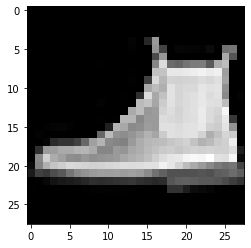

Label: 9


In [3]:
# 이미지와 정답(label)을 표시합니다.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[63].squeeze()
label = train_labels[63]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## 극복2. RNN & LSTM

이상하게, 그동안 언어 전처리를 하면 RNN/LSTM 분류 문제에서 원하는 값을 잘 주지 못하는 것 같다.  
다른 실습 코드를 바탕으로 RNN & LSTM를 활용한 classification 문제를 해결해보려고 한다.  
이를 바탕으로 그동안 어느 부분을 잘못 알고 있었는지를 확인한다.

### RNN 실습
RNN의 경우는 다음과 같은 코드를 바탕으로 실습했다.
https://wikidocs.net/60691

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data, datasets, legacy
import random

고정해야 하는 값들을 고정한다.

In [5]:
SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

# 하이퍼파라미터
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 10

CPU로 설정해서 진행하자.
또한 torch_text.legacy로 진행을 해야, 데이터가 나온다.

In [6]:
TEXT = legacy.data.Field(sequential=True, batch_first=True, lower=True)
LABEL = legacy.data.Field(sequential=False, batch_first=True)

atch_first는 신경망에 입력되는 텐서의 첫번째 차원값이 batch_size가 되도록 합니다.   
그리고 lower 변수를 통해 텍스트 데이터 속 모든 영문 알파벳이 소문자가 되도록 합니다.  
소문자 처리를 하지 않을 경우 Apple과 apple을 동일하게 여길 수 없습니다. 따라서 소문자 통일화는 필수.

In [7]:
# 전체 데이터를 훈련 데이터와 테스트 데이터를 8:2 비율로 나누기
trainset, testset = legacy.datasets.IMDB.splits(TEXT, LABEL)

In [8]:
# 단어 집합의 생성
# min_freq를 통해서 5번도 안나온 단어는 <unk>가 될 것이다.
TEXT.build_vocab(trainset, min_freq=5) # 단어 집합 생성
LABEL.build_vocab(trainset)

In [9]:
trainset, valset = trainset.split(split_ratio=0.8)

토치텍스트는 모든 텍스트를 배치 처리하는 것을 지원하고, 
단어를 인덱스 번호로 대체하는 BucketIterator를 제공합니다. 
BucketIterator는 batch_size, device, shuffle 등의 인자를 받습니다. BATCH_SIZE는 앞서 64로 설정했었습니다.

In [12]:
train_iter, val_iter, test_iter = legacy.data.BucketIterator.splits(
        (trainset, valset, testset), batch_size=BATCH_SIZE,
        shuffle=True, repeat=False)

이 과정을 통해서, sample과 label이 64개씩 묶여서 미니배치를 이루게 된다.

In [13]:
class GRU(nn.Module):
    def __init__(self, n_layers, hidden_dim, n_vocab, embed_dim, n_classes, dropout_p=0.2):
        super(GRU, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(n_vocab, embed_dim)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(embed_dim, self.hidden_dim,
                          num_layers=self.n_layers,
                          batch_first=True)
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        x = self.embed(x)
        h_0 = self._init_state(batch_size=x.size(0)) # 첫번째 히든 스테이트를 0벡터로 초기화
        x, _ = self.gru(x, h_0)  # GRU의 리턴값은 (배치 크기, 시퀀스 길이, 은닉 상태의 크기)
        h_t = x[:,-1,:] # (배치 크기, 은닉 상태의 크기)의 텐서로 크기가 변경됨. 즉, 마지막 time-step의 은닉 상태만 가져온다.
        self.dropout(h_t)
        logit = self.out(h_t)  # (배치 크기, 은닉 상태의 크기) -> (배치 크기, 출력층의 크기)
        return logit

    def _init_state(self, batch_size=1):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [15]:
vocab_size = len(TEXT.vocab)
n_classes = 2

In [16]:
model = GRU(1, 256, vocab_size, 128, n_classes, 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [20]:
def train(model, optimizer, train_iter):
    model.train()
    for b, batch in enumerate(train_iter):
        x, y = batch.text, batch.label
        y.data.sub_(1)  # 레이블 값을 0과 1로 변환
        optimizer.zero_grad()

        logit = model(x)
        loss = F.cross_entropy(logit, y)
        loss.backward()
        optimizer.step()

In [21]:
def evaluate(model, val_iter):
    """evaluate model"""
    model.eval()
    corrects, total_loss = 0, 0
    for batch in val_iter:
        x, y = batch.text, batch.label
        y.data.sub_(1) # 레이블 값을 0과 1로 변환
        logit = model(x)
        loss = F.cross_entropy(logit, y, reduction='sum')
        total_loss += loss.item()
        corrects += (logit.max(1)[1].view(y.size()).data == y.data).sum()
    size = len(val_iter.dataset)
    avg_loss = total_loss / size
    avg_accuracy = 100.0 * corrects / size
    return avg_loss, avg_accuracy

In [22]:
best_val_loss = None
for e in range(1, EPOCHS+1):
    train(model, optimizer, train_iter)
    val_loss, val_accuracy = evaluate(model, val_iter)

    print("[Epoch: %d] val loss : %5.2f | val accuracy : %5.2f" % (e, val_loss, val_accuracy))

    # 검증 오차가 가장 적은 최적의 모델을 저장
    if not best_val_loss or val_loss < best_val_loss:
        if not os.path.isdir("snapshot"):
            os.makedirs("snapshot")
        torch.save(model.state_dict(), './snapshot/txtclassification.pt')
        best_val_loss = val_loss

[Epoch: 1] val loss :  0.70 | val accuracy : 50.56
[Epoch: 2] val loss :  0.67 | val accuracy : 58.38


KeyboardInterrupt: 